In [19]:
!pip install kmodes

In [20]:
import pandas as pd
import numpy as np
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# **Clustering**

FATAL ACCIDENT K-MODES CLUSTERING (V2)

[1/5] Loading and filtering data to drivers...
   Total persons in dataset: 92,400
   Total drivers: 57,939

[2/5] Defining features and handling missing values...
   Using 18 features for clustering:
      - Binary features: 19
      - Categorical features: 5 (TIME_OF_DAY, SEASON, AGE_GROUP, ALCOHOL_LEVEL)

   ⚠️  Removed 2,214 rows with missing values (3.8%)
   Remaining drivers: 55,725

[3/5] Preparing data for clustering (using ALL drivers)...
   Total drivers for clustering: 55,725
   Unique accidents represented: 35,995
   Average drivers per accident: 1.55
   Final clustering dataset shape: (55725, 18)

[4/5] Determining optimal number of clusters using elbow method...
   Testing k values from 2 to 10...
      k=2, cost=269056.00
      k=3, cost=256796.00
      k=4, cost=242167.00
      k=5, cost=234373.00
      k=6, cost=227144.00
      k=7, cost=227008.00
      k=8, cost=221670.00
      k=9, cost=214055.00
      k=10, cost=207694.00

   

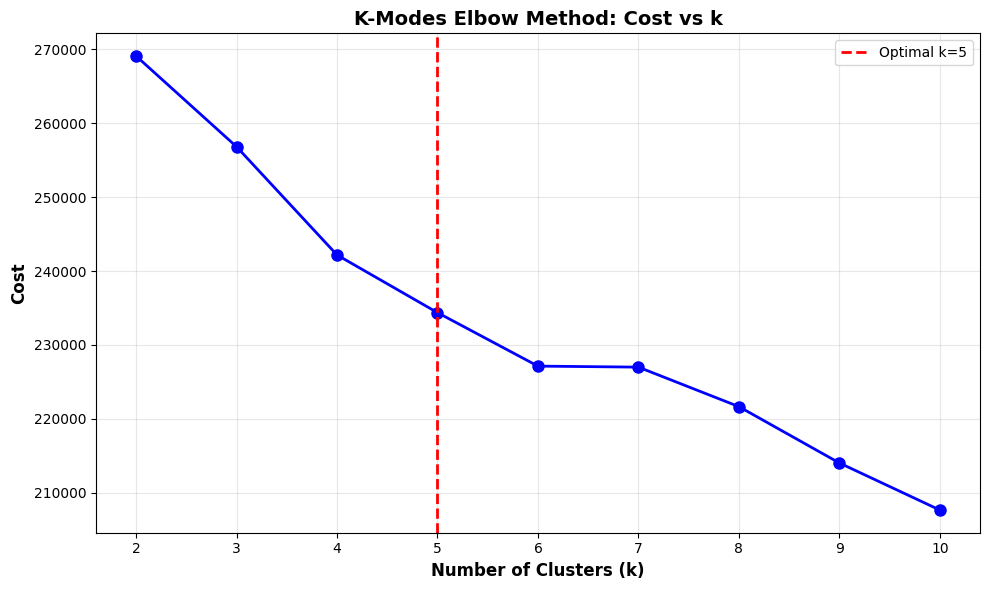

In [21]:
print("="*80)
print("FATAL ACCIDENT K-MODES CLUSTERING (V2)")
print("="*80)

# ============================================================================
# STEP 1: Load and Filter Data
# ============================================================================
print("\n[1/5] Loading and filtering data to drivers...")

# Load person-level engineered data
df = pd.read_parquet('person_level_engineered.parquet')
print(f"   Total persons in dataset: {len(df):,}")

# Filter to drivers only (PER_TYP == 1)
drivers = df[df['PER_TYP'] == 1].copy()
print(f"   Total drivers: {len(drivers):,}")

# ============================================================================
# STEP 2: Define Features and Remove Missing Values
# ============================================================================
print("\n[2/5] Defining features and handling missing values...")

# Define 24 clustering features
features = [
    # Binary features (19)
    'RUSH_HOUR',
    'MALE',
    #'DRUG_INVOLVED',
    # 'SPEEDING',
    # 'NO_RESTRAINT',
    'ADVERSE_WEATHER',
    'DARK_CONDITIONS',
    'OLD_VEHICLE',
    'PASSENGER_CAR',
    'LARGE_TRUCK',
    'MOTORCYCLE',
    # 'VEHICLE_TYPE',
    # 'RURAL',
    'URBAN',
    'INTERSTATE',
    'INTERSECTION',
    'WORK_ZONE_CRASH',
    'ROLLOVER_CRASH',
    'FIRE',
    'WEEKEND_FLAG',

    # Categorical features (5)
    'TIME_OF_DAY',      # Morning/Afternoon/Evening/Night
    'SEASON',           # Winter/Spring/Summer/Fall
    'AGE_GROUP',        # Teen/Young/Adult/Senior
    # 'ALCOHOL_LEVEL',     # High/Low (+ missing)
    #'DRUG_STATUS'       # Detected/Not detected/Unknown (+ missing)
]

print(f"   Using {len(features)} features for clustering:")
print(f"      - Binary features: 19")
print(f"      - Categorical features: 5 (TIME_OF_DAY, SEASON, AGE_GROUP, ALCOHOL_LEVEL)")

before_count = len(drivers)
drivers_clean = drivers.dropna(subset=features).copy()
removed = before_count - len(drivers_clean)

print(f"\n   ⚠️  Removed {removed:,} rows with missing values ({removed/before_count*100:.1f}%)")
print(f"   Remaining drivers: {len(drivers_clean):,}")

# ============================================================================
# STEP 3: Prepare Data for Clustering
# ============================================================================
print("\n[3/5] Preparing data for clustering (using ALL drivers)...")

# Use all drivers (no aggregation to accident level)
print(f"   Total drivers for clustering: {len(drivers_clean):,}")
print(f"   Unique accidents represented: {drivers_clean['ST_CASE'].nunique():,}")
print(f"   Average drivers per accident: {len(drivers_clean) / drivers_clean['ST_CASE'].nunique():.2f}")

# Extract clustering data
X = drivers_clean[features].copy()

# Convert all features to strings for K-Modes
for col in X.columns:
    X[col] = X[col].astype(str)

print(f"   Final clustering dataset shape: {X.shape}")

# ============================================================================
# STEP 4: Determine Optimal Number of Clusters and Run K-Modes
# ============================================================================
print("\n[4/5] Determining optimal number of clusters using elbow method...")

# Test different values of k
k_range = range(2, 11)
costs = []

print("   Testing k values from 2 to 10...")
for k in k_range:
    km = KModes(n_clusters=k, init='Cao', n_init=5, verbose=0, random_state=42)
    km.fit(X)
    costs.append(km.cost_)
    print(f"      k={k}, cost={km.cost_:.2f}")

# Find optimal k using elbow method
# Calculate distance from line connecting first and last point
costs_normalized = (np.array(costs) - np.min(costs)) / (np.max(costs) - np.min(costs))
k_normalized = (np.array(k_range) - k_range[0]) / (k_range[-1] - k_range[0])

# Calculate distance from line connecting first and last point
distances = []
for i in range(len(costs_normalized)):
    x0, y0 = k_normalized[i], costs_normalized[i]
    x1, y1 = 0, costs_normalized[0]
    x2, y2 = 1, costs_normalized[-1]

    dist = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1) / np.sqrt((y2-y1)**2 + (x2-x1)**2)
    distances.append(dist)

optimal_k = k_range[np.argmax(distances)]
print(f"\n   Optimal k based on elbow method: {optimal_k}")

# Run final clustering with optimal k
print(f"\n   Running final K-Modes clustering with k={optimal_k}...")
km_final = KModes(n_clusters=6, init='Cao', n_init=10, verbose=1, random_state=42) # Changed n_clusters to optimal_k
clusters = km_final.fit_predict(X)

# Add cluster assignments to data
drivers_clean['cluster'] = clusters

print(f"\n   Clustering complete!")
print(f"   Final cost: {km_final.cost_:.2f}")

# ============================================================================
# STEP 5: Save Results and Print Summary
# ============================================================================
print(f"\n[5/5] Saving results...")

extra_pattern_cols = [
    'MAN_COLLNAME',
    'M_HARMNAME',
    'REST_USENAME',
    'SPEEDRELNAME',
    'REL_ROADNAME',
]

# Keep only the ones that exist
extra_pattern_cols = [col for col in extra_pattern_cols if col in df.columns]

output_file = 'data/processed2/fatal_accident_clusters_v2.parquet'
os.makedirs(os.path.dirname(output_file), exist_ok=True)

# Build final output table
final_output = drivers_clean[
    ['ST_CASE', 'PER_NO', 'cluster'] + features + extra_pattern_cols
]

final_output.to_parquet(output_file, index=False)
print(f"   ✓ Cluster assignments saved to: {output_file}")

cluster_sizes = pd.Series(clusters).value_counts().sort_index()
print(f"\n   Cluster size distribution:")
for cluster_id, size in cluster_sizes.items():
    percentage = size / len(clusters) * 100
    print(f"      Cluster {cluster_id}: {size:,} drivers ({percentage:.1f}%)")


print(f"\n   Computing within-cluster homogeneity...")
homogeneity_scores = []
for cluster_id in range(optimal_k):
    cluster_data = X[clusters == cluster_id]

    agreements = []
    for col in X.columns:
        mode_val = cluster_data[col].mode()[0]
        agreement = (cluster_data[col] == mode_val).sum() / len(cluster_data)
        agreements.append(agreement)

    avg_homogeneity = np.mean(agreements)
    homogeneity_scores.append(avg_homogeneity)
    print(f"      Cluster {cluster_id}: {avg_homogeneity:.1%} average feature agreement")

print(f"\n   Overall average homogeneity: {np.mean(homogeneity_scores):.1%}")
print(f"   (Higher = more similar within clusters)")

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(k_range, costs, 'bo-', linewidth=2, markersize=8)
ax.axvline(x=optimal_k, color='red', linestyle='--', linewidth=2, label=f'Optimal k={optimal_k}')
ax.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax.set_ylabel('Cost', fontsize=12, fontweight='bold')
ax.set_title('K-Modes Elbow Method: Cost vs k', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()

elbow_plot_file = 'data/processed2/kmodes_elbow_v2.png'
os.makedirs(os.path.dirname(elbow_plot_file), exist_ok=True)
plt.savefig(elbow_plot_file, dpi=300, bbox_inches='tight')
print(f"\n   ✓ Elbow plot saved to: {elbow_plot_file}")


print("\n" + "="*80)
print("CLUSTERING ANALYSIS COMPLETE!")
print("="*80)
print(f"\nSummary:")
print(f"   • Total drivers clustered: {len(drivers_clean):,}")
print(f"   • Unique accidents represented: {drivers_clean['ST_CASE'].nunique():,}")
print(f"   • Number of clusters: {optimal_k}")
print(f"   • Average homogeneity: {np.mean(homogeneity_scores):.1%}")
print(f"   • Features used: {len(features)} (19 binary + 5 categorical)")
print(f"\nOutput files:")
print(f"   • {output_file}")
print(f"   • {elbow_plot_file}")
print("\n" + "="*80)

# **Cluster Visualization**

CLUSTER VISUALIZATION - BINARY FEATURE EXPANSION (V2)

[1/3] Loading data...
   Cluster assignments loaded: 55,725 drivers
   Unique accidents: 35,995

[2/3] Defining binary feature expansion function...
   ✓ Binary feature expansion function defined

[3/3] Creating individual histograms for each cluster...
   Number of clusters: 6
   Cluster 0: 16 features >65% prevalent (saved to data/processed/cluster_0_features.png)


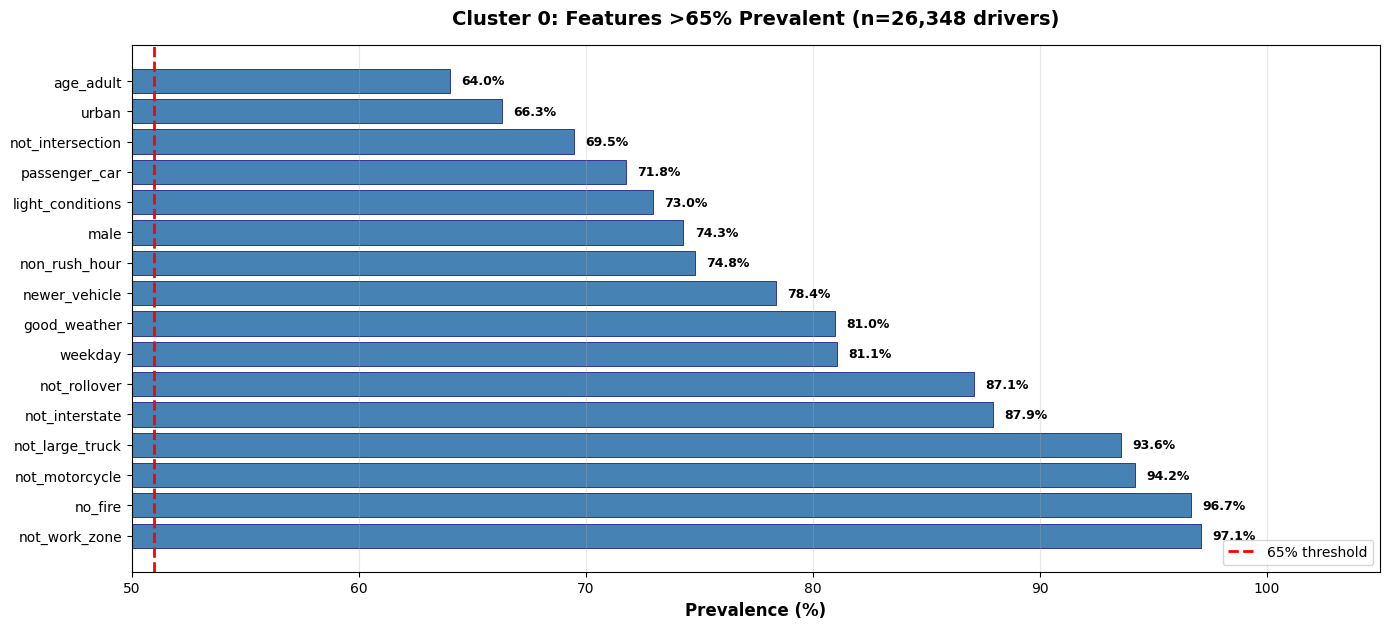

   Cluster 1: 17 features >65% prevalent (saved to data/processed/cluster_1_features.png)


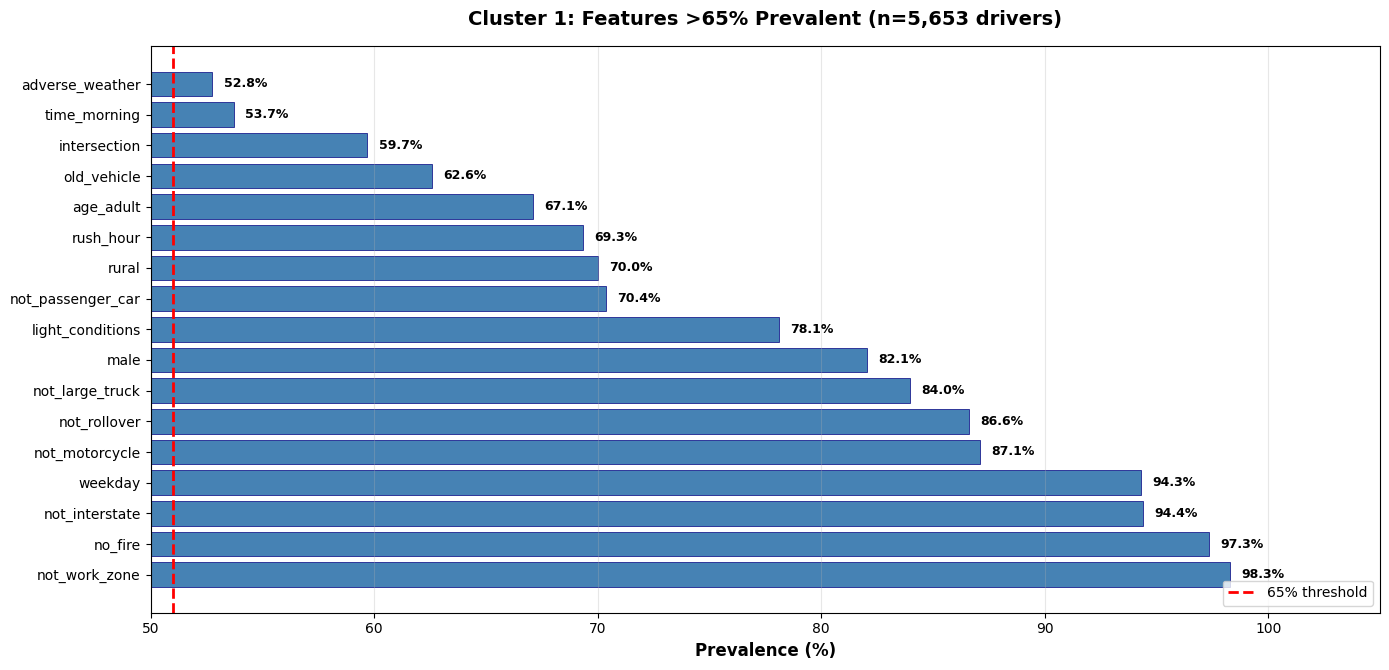

   Cluster 2: 17 features >65% prevalent (saved to data/processed/cluster_2_features.png)


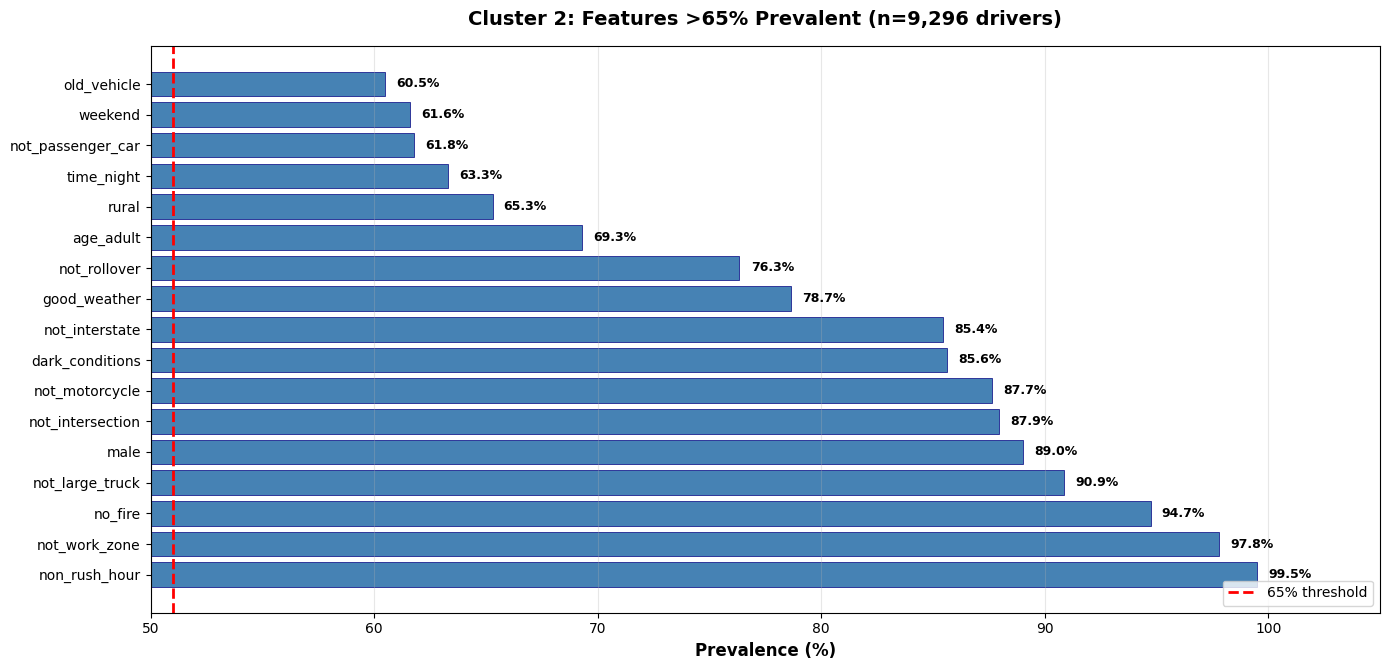

   Cluster 3: 17 features >65% prevalent (saved to data/processed/cluster_3_features.png)


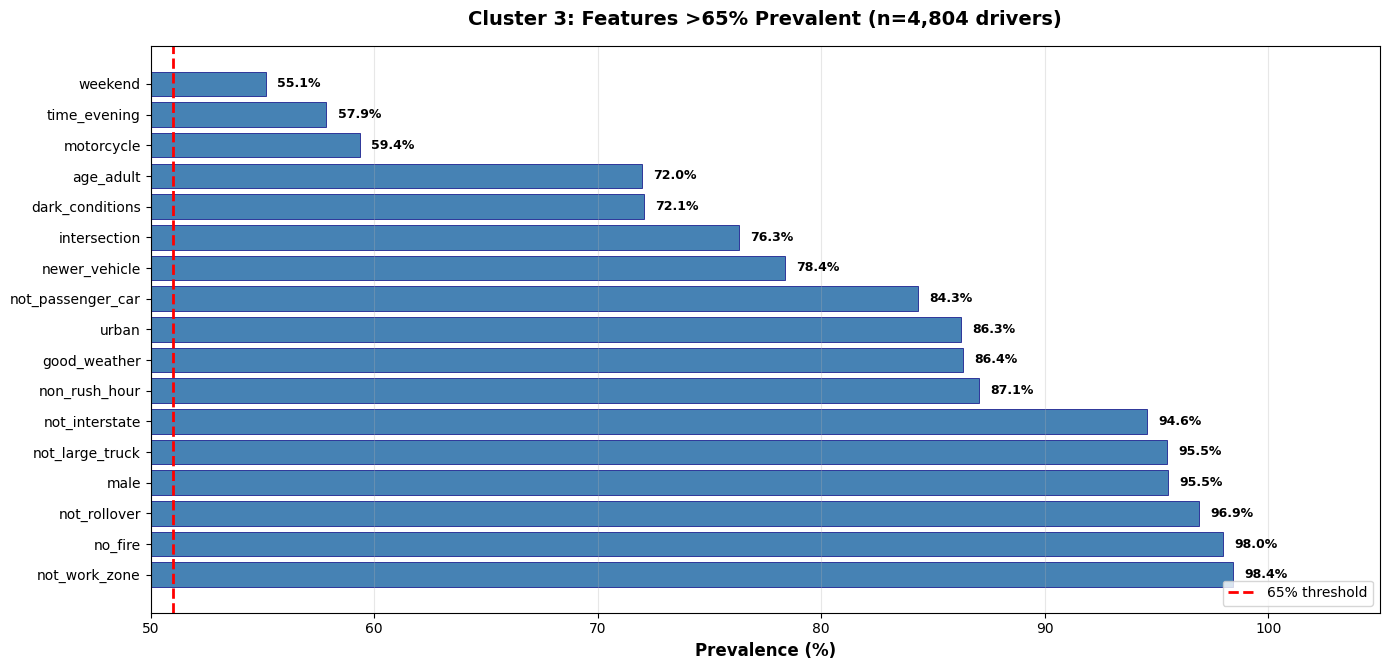

   Cluster 4: 17 features >65% prevalent (saved to data/processed/cluster_4_features.png)


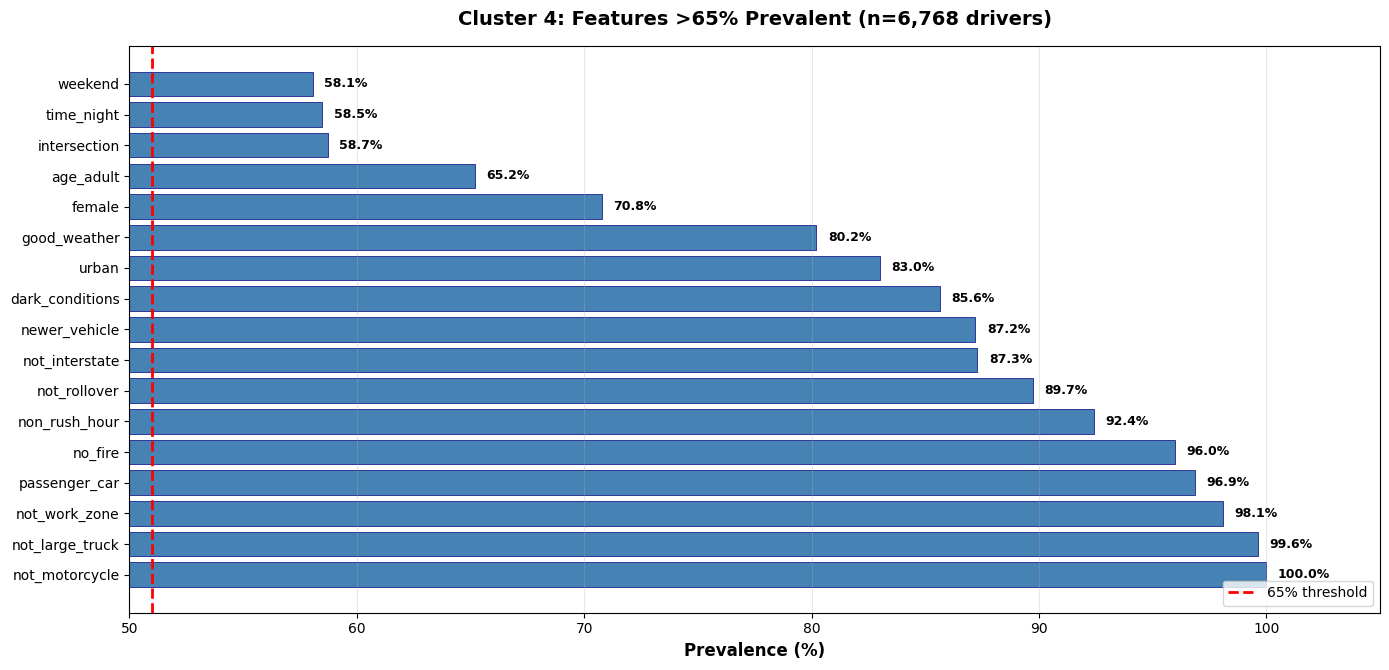

   Cluster 5: 16 features >65% prevalent (saved to data/processed/cluster_5_features.png)


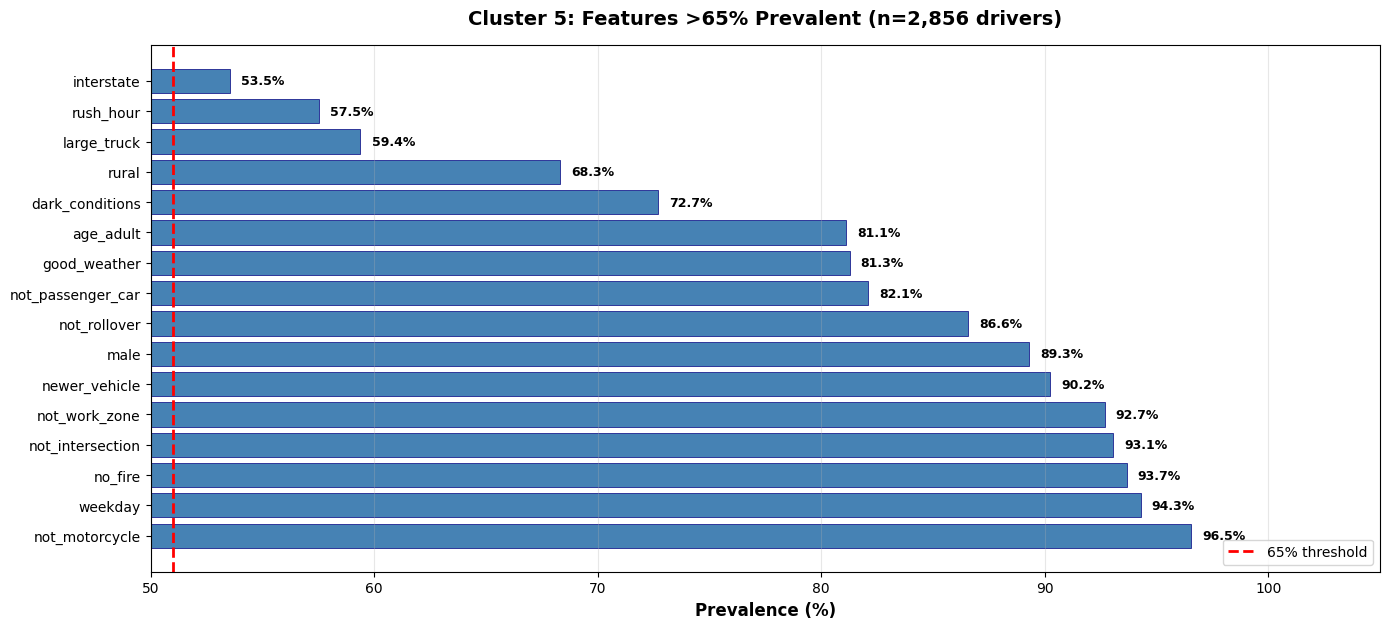


VISUALIZATION COMPLETE!

Summary:
   • Total clusters visualized: 6
   • Features shown: Only those with >65% prevalence
   • Binary expansion: All binary features shown as both options
   • Categorical expansion: All categories shown separately
   • Individual files created for each cluster



In [22]:
"""
Fatal Accident Cluster Visualization (Version 2)
Shows features >65% prevalent in each cluster with binary feature expansion
"""

print("="*80)
print("CLUSTER VISUALIZATION - BINARY FEATURE EXPANSION (V2)")
print("="*80)

# ============================================================================
# Load Data
# ============================================================================
print("\n[1/3] Loading data...")

# Load cluster assignments (now includes all features)
clusters_df = pd.read_parquet('/content/data/processed2/fatal_accident_clusters_v2.parquet')
print(f"   Cluster assignments loaded: {len(clusters_df):,} drivers")
print(f"   Unique accidents: {clusters_df['ST_CASE'].nunique():,}")

# ============================================================================
# Define Binary Feature Expansion Function
# ============================================================================
print("\n[2/3] Defining binary feature expansion function...")

def create_binary_features(data, cluster_id):
    """
    Create binary representation for ALL features
    Returns dict of feature_name: prevalence_percentage

    For binary features: Creates both 'feature' and 'not_feature'
    For categorical features: Creates all category options
    """
    cluster_data = data[data['cluster'] == cluster_id]
    if len(cluster_data) == 0:
        return {}

    features = {}

    # Binary features - create both options (complementary)
    binary_features = {
        'RUSH_HOUR': ('rush_hour', 'non_rush_hour'),
        'MALE': ('male', 'female'),
        'DRUG_INVOLVED': ('drug_involved', 'no_drugs'),
        'SPEEDING': ('speeding', 'not_speeding'),
        'NO_RESTRAINT': ('no_seatbelt', 'seatbelt'),
        'ADVERSE_WEATHER': ('adverse_weather', 'good_weather'),
        'DARK_CONDITIONS': ('dark_conditions', 'light_conditions'),
        'OLD_VEHICLE': ('old_vehicle', 'newer_vehicle'),
        'PASSENGER_CAR': ('passenger_car', 'not_passenger_car'),
        'LARGE_TRUCK': ('large_truck', 'not_large_truck'),
        'MOTORCYCLE': ('motorcycle', 'not_motorcycle'),
        'RURAL': ('rural', 'urban'),
        'URBAN': ('urban', 'rural'),
        'INTERSTATE': ('interstate', 'not_interstate'),
        'INTERSECTION': ('intersection', 'not_intersection'),
        'WORK_ZONE_CRASH': ('work_zone', 'not_work_zone'),
        'ROLLOVER_CRASH': ('rollover', 'not_rollover'),
        'FIRE': ('fire', 'no_fire')
    }

    for feat, (positive_label, negative_label) in binary_features.items():
        if feat in cluster_data.columns:
            pct = (cluster_data[feat] == 1).sum() / len(cluster_data) * 100
            features[positive_label] = pct
            features[negative_label] = 100 - pct

    # WEEKEND_FLAG (string: "Weekend"/"Weekday")
    if 'WEEKEND_FLAG' in cluster_data.columns:
        weekend_pct = (cluster_data['WEEKEND_FLAG'] == 'Weekend').sum() / len(cluster_data) * 100
        features['weekend'] = weekend_pct
        features['weekday'] = 100 - weekend_pct

    # TIME_OF_DAY (4 categories)
    if 'TIME_OF_DAY' in cluster_data.columns:
        time_dist = cluster_data['TIME_OF_DAY'].value_counts(normalize=True) * 100
        features['time_morning'] = time_dist.get('Morning', 0)
        features['time_afternoon'] = time_dist.get('Afternoon', 0)
        features['time_evening'] = time_dist.get('Evening', 0)
        features['time_night'] = time_dist.get('Night', 0)

    if 'VEHICLE_TYPE' in cluster_data.columns:
        time_dist = cluster_data['VEHICLE_TYPE'].value_counts(normalize=True) * 100
        features['passenger_car'] = time_dist.get('Passenger Car', 0)
        features['motorcycle'] = time_dist.get('Motorcycle', 0)
        features['large_truck'] = time_dist.get('Large truck', 0)
        features['other'] = time_dist.get('Other', 0)

    if 'ALCOHOL_LEVEL' in cluster_data.columns:
        alcohol_dist = cluster_data['ALCOHOL_LEVEL'].value_counts(normalize=True, dropna=False) * 100
        features["High"] = alcohol_dist.get('alcohol_High', 0)
        features["Low"] = alcohol_dist.get('alcohol_Low', 0)
        features["None"] = alcohol_dist.get('alcohol_None', 0)
        features["Unknown"] = alcohol_dist.get('alcohol_Unknown', 0)

    if 'DRUG_STATUS' in cluster_data.columns:
        drug_dist = cluster_data['DRUG_STATUS'].value_counts(normalize=True, dropna=False) * 100
        features["Detected"] = drug_dist.get('drugs_Detected', 0)
        features["Not detected"] = drug_dist.get('drugs_Not detected', 0)
        features["Unknown"] = drug_dist.get('drugs_Unknown', 0)

    # SEASON (4 categories)
    if 'SEASON' in cluster_data.columns:
        season_dist = cluster_data['SEASON'].value_counts(normalize=True) * 100
        features['season_winter'] = season_dist.get('Winter', 0)
        features['season_spring'] = season_dist.get('Spring', 0)
        features['season_summer'] = season_dist.get('Summer', 0)
        features['season_fall'] = season_dist.get('Fall', 0)

    # AGE_GROUP (4 categories)
    if 'AGE_GROUP' in cluster_data.columns:
        age_dist = cluster_data['AGE_GROUP'].value_counts(normalize=True) * 100
        features['age_teen'] = age_dist.get('Teen', 0)
        features['age_young'] = age_dist.get('Young', 0)
        features['age_adult'] = age_dist.get('Adult', 0)
        features['age_senior'] = age_dist.get('Senior', 0)

    return features

print("   ✓ Binary feature expansion function defined")

# ============================================================================
# Create Individual Histograms for Each Cluster
# ============================================================================
print("\n[3/3] Creating individual histograms for each cluster...")

# Get unique clusters
clusters = sorted(clusters_df['cluster'].unique())
n_clusters = len(clusters)
print(f"   Number of clusters: {n_clusters}")

# Create a histogram for each cluster
for cluster_id in clusters:
    # Get binary features for this cluster
    features_dict = create_binary_features(clusters_df, cluster_id)

    # Filter to >65% prevalence
    high_prev_features = {k: v for k, v in features_dict.items() if v > 51}

    # Sort by prevalence (descending)
    sorted_features = dict(sorted(high_prev_features.items(), key=lambda x: x[1], reverse=True))

    # Get cluster size
    cluster_size = len(clusters_df[clusters_df['cluster'] == cluster_id])

    # Create figure for this cluster
    fig, ax = plt.subplots(figsize=(14, max(6, len(sorted_features) * 0.4)))

    if len(sorted_features) > 0:
        names = list(sorted_features.keys())
        values = list(sorted_features.values())

        # Create horizontal bar chart
        bars = ax.barh(names, values, color='steelblue', edgecolor='navy', linewidth=0.5)

        # Styling
        ax.set_xlabel('Prevalence (%)', fontsize=12, fontweight='bold')
        ax.set_title(f'Cluster {cluster_id}: Features >65% Prevalent (n={cluster_size:,} drivers)',
                     fontsize=14, fontweight='bold', pad=15)
        ax.axvline(x=51, color='red', linestyle='--', linewidth=2, label='65% threshold')
        ax.set_xlim(50, 105)  # Start at 70 to focus on high-prevalence features
        ax.legend(loc='lower right', fontsize=10)
        ax.grid(axis='x', alpha=0.3)

        # Add value labels on bars
        for bar, val in zip(bars, values):
            ax.text(val + 0.5, bar.get_y() + bar.get_height()/2,
                   f'{val:.1f}%', va='center', ha='left', fontsize=9, fontweight='bold')

        # Adjust y-tick labels for better readability
        ax.tick_params(axis='y', labelsize=10)
        ax.tick_params(axis='x', labelsize=10)

    else:
        # No features >65% in this cluster
        ax.text(0.5, 0.5, f'No features >65% prevalent\n(Cluster size: {cluster_size:,} drivers)',
               ha='center', va='center', fontsize=13, fontweight='bold',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')

    plt.tight_layout()

    # Save individual cluster visualization
    output_file = f'data/processed/cluster_{cluster_id}_features.png'
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"   Cluster {cluster_id}: {len(sorted_features)} features >65% prevalent (saved to {output_file})")

    plt.show()

print("\n" + "="*80)
print("VISUALIZATION COMPLETE!")
print("="*80)
print(f"\nSummary:")
print(f"   • Total clusters visualized: {n_clusters}")
print(f"   • Features shown: Only those with >65% prevalence")
print(f"   • Binary expansion: All binary features shown as both options")
print(f"   • Categorical expansion: All categories shown separately")
print(f"   • Individual files created for each cluster")
print("\n" + "="*80)
